| | |
| --- | --- |
| **Author** | Alessio Spurio Mancini |
| **email** | a.spuriomancini@ucl.ac.uk |

<div align="center"><img src='https://drive.google.com/uc?id=1KTafFIJzWQTBdtdd6xrI7OszfhpZYkVM' width="400" height="300"></div>

This notebook can also be run on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1TUDp1MWe0nU79JJXlsHBuMszWVpOLg7S?usp=sharing)

In this notebook we will see an example of how to run a complete inference pipeline with power spectra sourced from ``CosmoPower``. We will run a version of the _Planck_ 2018 ``lite`` likelihood, rewritten to be fully implemented in [TensorFlow](https://www.tensorflow.org/): ``tf_planck2018_lite``. The ``lite`` version of the _Planck_ likelihood is pre-marginalised over a set of nuisance parameters. The TensorFlow version of this likelihood, provided as part of ``CosmoPower``, is an adaptation for TensorFlow of the [planck-lite-py](https://github.com/heatherprince/planck-lite-py) likelihood written by H. Prince and J. Dunkley.

If you use ``tf_planck2018_lite``, _in addition_ to the ``CosmoPower`` [release paper](https://arxiv.org/abs/2106.03846) please also cite [Prince & Dunkley (2019)](https://arxiv.org/abs/1909.05869) and [Planck (2018)](https://arxiv.org/abs/1907.12875).

In [1]:
import numpy as np
import tensorflow as tf
#import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib inline

In [2]:
# checking that we are using a GPU
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu'
print('using', device, 'device \n')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
using cpu device 



2022-06-24 11:24:41.532952: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# TF_PLANCK2018_LITE

First we need to instantiate the emulators for the TT, TE, EE power spectra. These are required by the ``tf_planck2018_lite`` likelihood. In this example we will use the pre-trained model of the ``CosmoPower`` [release paper](https://arxiv.org/abs/2106.03846), available [here](https://github.com/alessiospuriomancini/cosmopower/blob/main/cosmopower/trained_models/CP_paper/CMB).

In [3]:
import cosmopower as cp
import os
ipynb_path = os.path.dirname(os.path.realpath("__file__"))

tt_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../../cosmopower/trained_models/CP_paper/CMB/cmb_TT_NN')
                               )

te_emu_model = cp.cosmopower_PCAplusNN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../../cosmopower/trained_models/CP_paper/CMB/cmb_TE_PCAplusNN')
                               )

ee_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../../cosmopower/trained_models/CP_paper/CMB/cmb_EE_NN')
                               )

ModuleNotFoundError: No module named 'cosmopower'

Now let's create an instance of the pure-TensorFlow version of the Planck 2018 lite likelihood, ``tf_planck2018_lite``. To do so, wwe import ``CosmoPower`` and remember to input:

- a path to the ``tf_planck2018_lite`` likelihood. It will be used to access the _Planck_ data;

- parameters of the analysis, as well as their priors;

- the ``CosmoPower`` emulators.
#- a fiducial set of points and ball radii to initialize the walkers

In [22]:
import cosmopower as cp
import tensorflow as tf 
import tensorflow_probability as tfp
# path to the tf_planck2018_lite likelihood
tf_planck2018_lite_path = './../../cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors = {'omega_b':      [0.001, 0.04, 'uniform'],
                         'omega_cdm':    [0.005, 0.99,  'uniform'],
                         'h':            [0.2,   1.0,   'uniform'],
                         'tau_reio':     [0.01,  0.8,   'uniform'],
                         'n_s':          [0.9,   1.1,   'uniform'],
                         'ln10^{10}A_s': [1.61,  3.91,  'uniform'],
                         'A_planck':     [1.0,   0.01,  'gaussian'],
                          }

# instantiation
tf_planck = cp.tf_planck2018_lite(parameters=parameters_and_priors, 
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  tt_emu_model=tt_emu_model,
                                  te_emu_model=te_emu_model,
                                  ee_emu_model=ee_emu_model
                                  )

# initial points
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.11977,  0.673,  0.055,  0.9658,  3.0753,  1.0080]).astype('float32'), (1, 7))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

### Target log probability

Takes tensor of (n_walkers, n_parameters) input parameter vectors, return shape (n_walkers,) i.e., the log probability for each of the input parameter vectors. This is the main output produced by ``tf_planck2018_lite`` (cf. its method ``posterior``).

In [23]:
@tf.function
def log_prob(theta):
    return tf.squeeze(tf_planck.posterior(theta), -1)

### Initialize the walkers
You need to initialize *two* sets of "walkers", each of shape (n_walkers, n_parameters), for the parallel affine sampler. It's generally a good idea to initialize walkers in a tight-ish ball close to some fiducial parameter guess (and the sampler will burn in from there). The two sets of walkers (put into a list) define the initial "current state" for the sampler.

In [24]:
# using emcee instead of affine.
import emcee

n_walkers=120
n_steps = 5000
n_dim = 7

# fiducial sample (or should be, this is only close to it)
theta0    = np.array([0.02,
                     0.01,
                     0.7,
                     0.05,
                     1.0,
                     3.1,
                     1.0],dtype=np.float32)

# Starting position of the emcee chain
print(theta0.shape)
print(np.random.normal(size=(n_walkers, n_dim)).shape)
pos0 = theta0[np.newaxis] + np.random.normal(size=(n_walkers, n_dim))/100
pos0 = pos0.astype(np.float32)

(7,)
(120, 7)


### Run the sampler!

In [25]:
#with Pool(10) as pool:
import sys

def log_prob(theta):
    p=tf_planck.posterior(theta.astype(np.float32)).numpy()
    return p

#import my edited likelihood code
sys.path.append(os.path.join(os.path.dirname("__file__"), '../../cosmopower'))
import likelihoods.tf_planck2018_lite as cppl

# instantiation
tf_planck = cppl(parameters=parameters_and_priors, 
                                  tf_planck2018_lite_path='/home/grads/data/evan/cosmopower/cosmopower/likelihoods/tf_planck2018_lite',
                                  tt_emu_model=tt_emu_model,
                                  te_emu_model=te_emu_model,
                                  ee_emu_model=ee_emu_model
                                  )

emu_sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob, vectorize=True)#, pool=pool)
emu_sampler.run_mcmc(pos0, n_steps, progress=True)
print('done!')

  0%|                                                                      | 0/5000 [00:00<?, ?it/s]/home/grads/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████| 5000/5000 [01:14<00:00, 66.82it/s]

done!


### Plot the results

In [26]:
# plot the results...

# how many burnin steps to remove
burnin_steps = 3000
samples = emu_sampler.chain[:,burnin_steps:].reshape((-1,n_dim))

In [27]:
from getdist import plots, MCSamples
names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s", 
         r"A_{\mathrm{Planck}}"]
labels = names
mcsamples = MCSamples(samples=samples,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 30
g.settings.legend_fontsize = 50

Removed no burn in


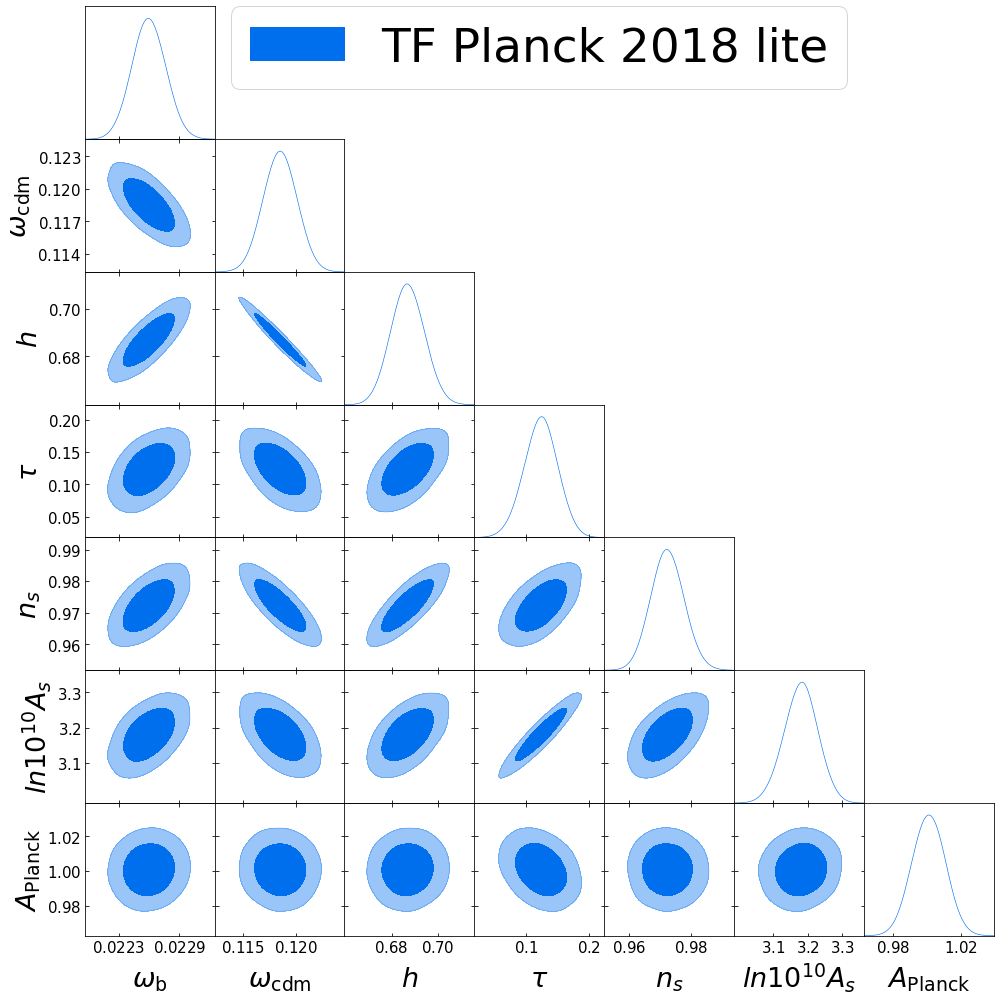

In [28]:
g.triangle_plot([mcsamples], filled=True, legend_labels=['TF Planck 2018 lite'])
plt.show()